# 1. Nhập dữ liệu

In [51]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("../data_for_modeling/filter_data/v1/HDAC2_test.csv")
train_dataset = pd.read_csv("../data_for_modeling/filter_data/v1/HDAC2_train.csv")

# 2. Xây dựng mô hình với Morgan2

## 2.1. Mã hóa cấu trúc phân tử

In [53]:
def maccs_fpts(data):
    Maccs_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = MACCSkeys.GenMACCSKeys(mol)
        mfpts = np.array(fpts)
        Maccs_fpts.append(mfpts)
    return np.array(Maccs_fpts)

In [54]:
train_maccs_fpts = maccs_fpts(train_dataset['SMILES'])
test_maccs_fpts = maccs_fpts(test_dataset['SMILES'])
X_Train = train_maccs_fpts
X_Test = test_maccs_fpts

In [55]:
y_Train = np.array(train_dataset['FINAL_LABEL'])
y_Test = np.array(test_dataset['FINAL_LABEL'])

## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf_maccs = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_maccs.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn_maccs = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_maccs.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [58]:
from sklearn.svm import SVC
svm_maccs = SVC(kernel='rbf', random_state=0)
svm_maccs.fit(X_Train, y_Train)

SVC(random_state=0)

__XGBoost__

In [59]:
from xgboost import XGBClassifier
bst_maccs = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_maccs.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [61]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

__RF__

In [62]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.786 (0.048)


__KNN__

In [63]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(knn_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.767 (0.051)


__SVM__

In [64]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.757 (0.044)


__XGBoost__

In [65]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(bst_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.790 (0.038)


### 2.3.2. Accuracy, Sensitivity, Specificity

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [67]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [68]:
def me_result(cm):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

RF

In [69]:
#Random Forest
y_rf_pred = rf_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_rf_pred)
me_result(cm)

Confusion matrix:
[[73 20]
 [23 81]]
Comparision:
╒══════════╤══════════╤══════════╤═════════╤══════════╕
│          │       AC │       SE │      SP │      MCC │
╞══════════╪══════════╪══════════╪═════════╪══════════╡
│ My model │ 0.781726 │ 0.760417 │ 0.80198 │ 0.563094 │
╘══════════╧══════════╧══════════╧═════════╧══════════╛


KNN

In [70]:
#KNN
y_knn_pred = knn_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_knn_pred)
me_result(cm)

Confusion matrix:
[[72 21]
 [27 77]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.756345 │ 0.727273 │ 0.785714 │ 0.513782 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


SVM

In [71]:
#SVM
y_svm_pred = svm_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_svm_pred)
me_result(cm)

Confusion matrix:
[[77 16]
 [31 73]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.761421 │ 0.712963 │ 0.820225 │ 0.531531 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


XGBoost

In [72]:
y_bst_pred = bst_maccs.predict(X_Test)
cm = confusion_matrix(y_Test, y_bst_pred)
me_result(cm)

Confusion matrix:
[[70 23]
 [26 78]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.751269 │ 0.729167 │ 0.772277 │ 0.502066 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


### 2.3.3. AUC

In [73]:
from sklearn.metrics import RocCurveDisplay

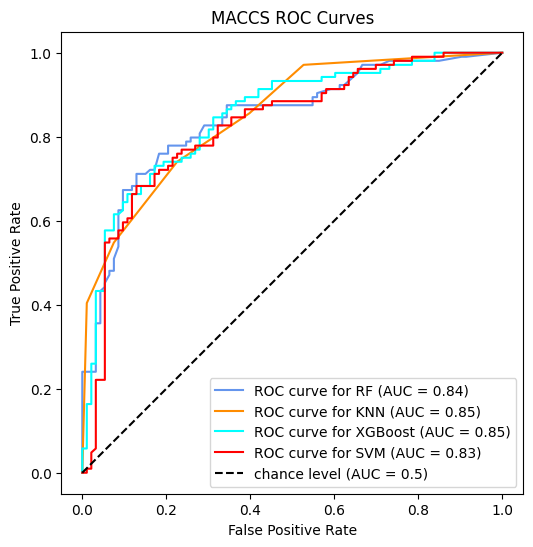

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MACCS ROC Curves")
plt.legend()
plt.show()